In [2]:
import numpy as np
import pandas as pd
import os
import random
from PIL import Image
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.optimizers import Adam
import seaborn as sns

2024-09-28 12:39:49.226216: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-28 12:39:50.197362: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-28 12:39:52.253761: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


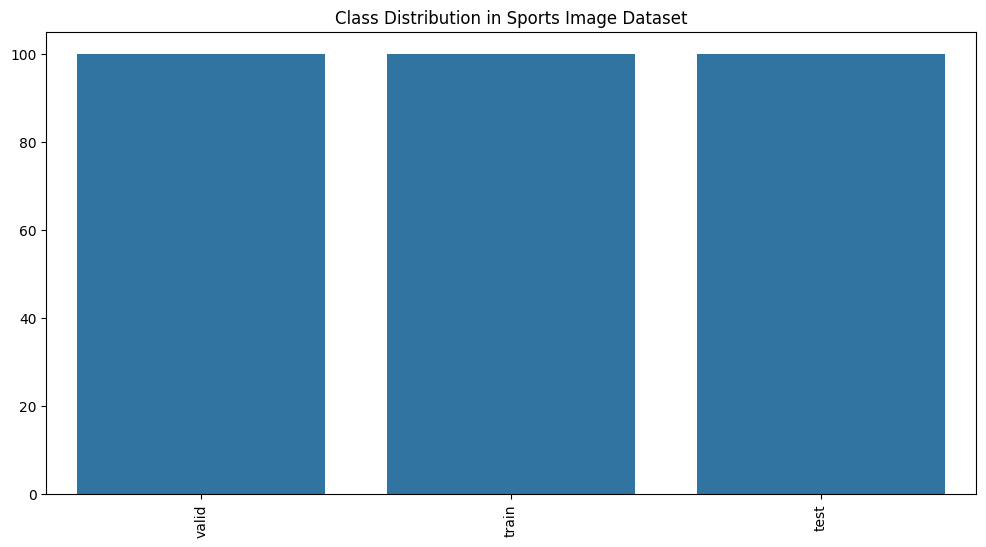

In [3]:
# 1. Plot Dataset Distribution
original_data_dir = '/home/sunbeam/Desktop/image_classification/sports-classification'
class_counts = {}
for class_dir in os.listdir(original_data_dir):
    if os.path.isdir(os.path.join(original_data_dir, class_dir)):
        class_counts[class_dir] = len(os.listdir(os.path.join(original_data_dir, class_dir)))

# Plot Class Distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=90)
plt.title("Class Distribution in Sports Image Dataset")
plt.show()

In [4]:
# Load dataset (We have images in a directory with class-wise folders)
train_data_dir = '/home/sunbeam/Desktop/image_classification/sports-classification/train'
val_data_dir = '/home/sunbeam/Desktop/image_classification/sports-classification/valid'
test_data_dir = '/home/sunbeam/Desktop/image_classification/sports-classification/test'

In [5]:
selected_classes = ['air hockey', 'ampute football', 'archery', 'arm wrestling',
                    'axe throwing', 'balance beam', 'barell racing', 'baseball',
                    'basketball', 'baton twirling']

In [6]:
train_datagen = ImageDataGenerator( zoom_range=0.2,
                            width_shift_range=0.2,height_shift_range=0.2)


train_dg = train_datagen.flow_from_directory(train_data_dir,
                                        classes = selected_classes,
                                    class_mode = "categorical",
                                    target_size = (299, 299),
                                    batch_size = 128,
                                    shuffle = True,
                                    seed = 42)

Found 1289 images belonging to 10 classes.


In [10]:
val_datagen = ImageDataGenerator()

validation_dg = val_datagen.flow_from_directory(val_data_dir,
                                      classes = selected_classes,
                                      class_mode = "categorical",
                                      target_size = (299, 299),
                                      batch_size = 10,
                                      shuffle = False,
                                      seed = 42)

Found 50 images belonging to 10 classes.


In [11]:
testing_dg = val_datagen.flow_from_directory(test_data_dir,
                                             classes = selected_classes,
                                      class_mode = "categorical",
                                      target_size = (299, 299),
                                      batch_size = 10,
                                      shuffle = False,
                                      seed = 42)

Found 50 images belonging to 10 classes.


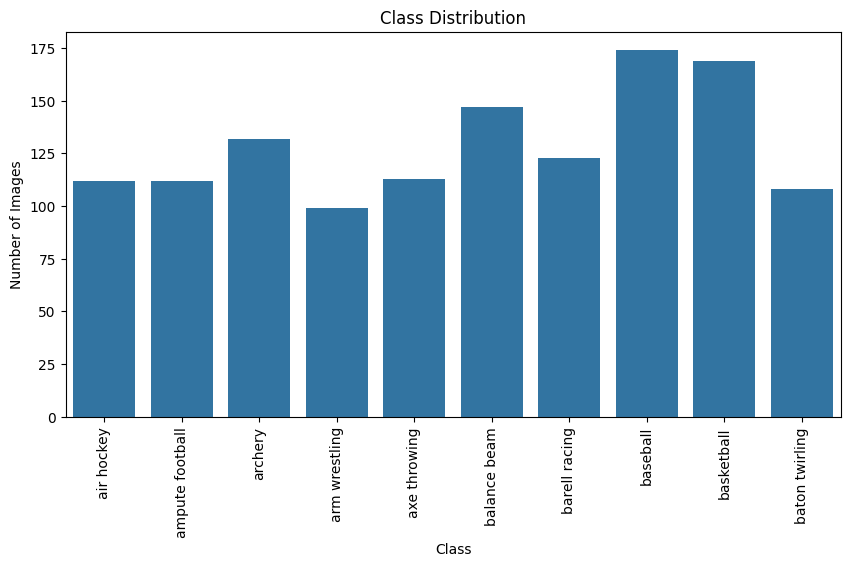

In [7]:
import seaborn as sns
def plot_class_distribution(generator):
    class_names = list(generator.class_indices.keys())
    class_counts = [sum(generator.classes == class_id) for class_id in range(len(class_names))]
    plt.figure(figsize=(10, 5))
    sns.barplot(x=class_names, y=class_counts)
    plt.xticks(rotation=90)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution')
    plt.show()

plot_class_distribution(train_dg)

In [8]:
def create_local_feature_extractor(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1024, activation='relu')
    ])
    return model

input_shape = (299, 299, 3)
local_feature_extractor = create_local_feature_extractor(input_shape)

/home/sunbeam/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
def extract_local_features(generator, model):
    features = []
    labels = []
    for batch in generator:
        x_batch, y_batch = batch
        features_batch = model.predict(x_batch)
        features.append(features_batch)
        labels.append(y_batch)
        if len(features) * generator.batch_size >= generator.samples:
            break
    return np.vstack(features), np.vstack(labels)

# Extract local features
local_train_features, local_train_labels = extract_local_features(train_dg, local_feature_extractor)
local_validation_features, local_validation_labels = extract_local_features(validation_dg, local_feature_extractor)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


In [13]:
local_train_features.shape

(1289, 1024)

In [14]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model

def create_global_feature_extractor(input_shape):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    return Model(inputs=base_model.input, outputs=x)

# Create models
global_feature_extractor = create_global_feature_extractor((299, 299, 3))

def extract_global_features(generator, model):
    features = []
    labels = []
    for batch in generator:
        x_batch, y_batch = batch
        features_batch = model.predict(x_batch)
        features.append(features_batch)
        labels.append(y_batch)
        if len(features) * generator.batch_size >= generator.samples:
            break
    return np.vstack(features), np.vstack(labels)

# Extract global features
global_train_features, global_train_labels = extract_global_features(train_dg, global_feature_extractor)
global_validation_features, global_validation_labels = extract_global_features(validation_dg, global_feature_extractor)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


In [15]:
fused_train_features = np.stack((local_train_features.reshape(1289,32,32),
         global_train_features.reshape(1289,32,32)),axis=3)

In [16]:
fused_validation_features = np.stack((local_validation_features.reshape(50,32,32),
         global_validation_features.reshape(50,32,32)),axis=3)

In [17]:
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, Conv2D, AveragePooling2D
from tensorflow.keras.models import Model, Sequential

def create_combined_model(num_classes):
    
    model = Sequential()
    model.add(layers.Conv2D(64,(3,3),activation='relu',padding="same", input_shape=(32,32, 2)))
    model.add(layers.Conv2D(128,(5,5),activation='relu',padding="same"))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128,(3,3),padding="same", activation='relu'))
    model.add(layers.Conv2D(64,(5,5),padding="same", activation='relu'))
    model.add(layers.AveragePooling2D((2, 2)))
    
    model.add(layers.Conv2D(64,(3,3),padding="same", activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.1))
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.1))

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.1))

    model.add(Dense(num_classes, activation='softmax'))
    return model

# Create the combined model
num_classes = len(selected_classes)
combined_model = create_combined_model(num_classes)
combined_model.summary()

# Compile the model
opt = Adam(learning_rate=0.0001)
combined_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 64)     │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 8, 8, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │     4,198,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     4,195,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,519,178 (36.31 MB)

 Trainable params: 9,519,178 (36.31 MB)

 Non-trainable params: 0 (0.00 B)

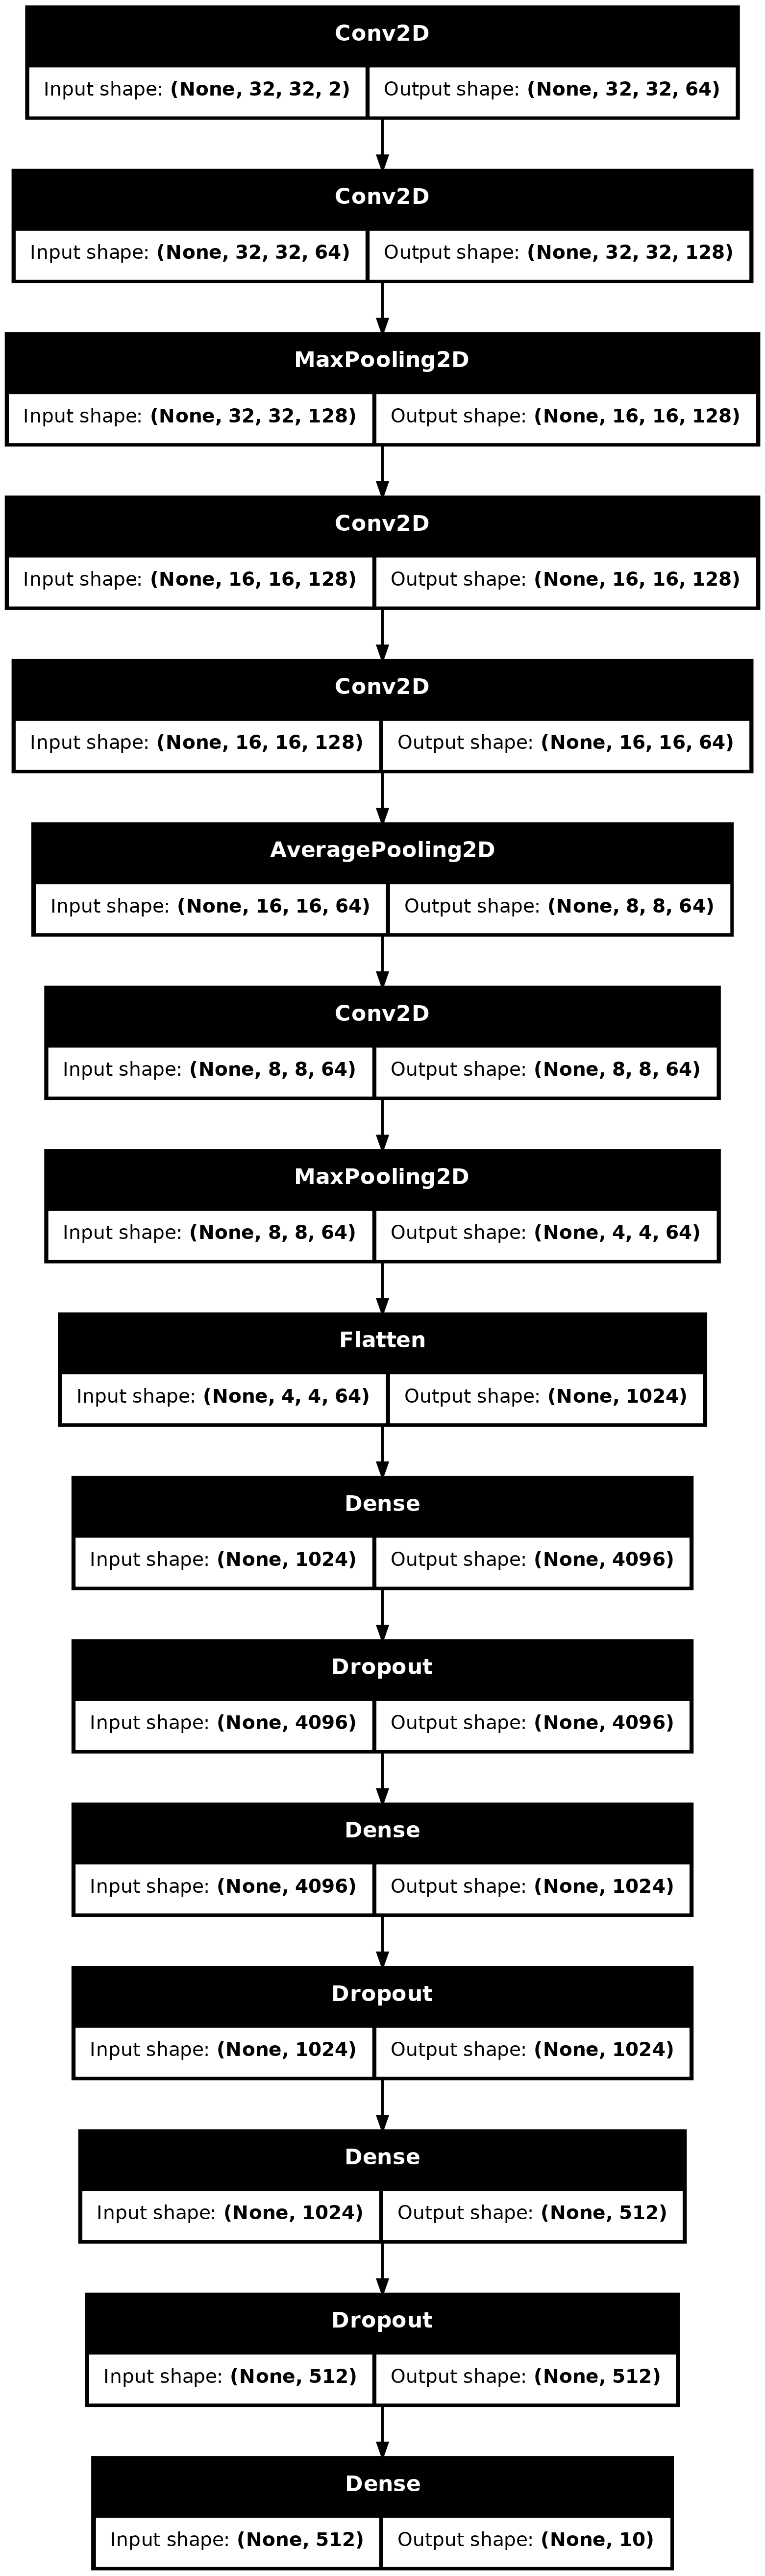

In [18]:
keras.utils.plot_model(combined_model, show_shapes=True)


Epoch 1/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 760ms/step - accuracy: 0.1218 - loss: 2.3040 - val_accuracy: 0.1000 - val_loss: 2.3203
Epoch 2/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 778ms/step - accuracy: 0.1270 - loss: 2.2969 - val_accuracy: 0.1000 - val_loss: 2.3404
Epoch 3/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 825ms/step - accuracy: 0.1460 - loss: 2.2817 - val_accuracy: 0.1000 - val_loss: 2.3125
Epoch 4/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 864ms/step - accuracy: 0.1397 - loss: 2.2873 - val_accuracy: 0.1000 - val_loss: 2.3286
Epoch 5/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 820ms/step - accuracy: 0.1340 - loss: 2.2909 - val_accuracy: 0.1000 - val_loss: 2.3124
Epoch 6/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 824ms/step - accuracy: 0.1341 - loss: 2.2888 - val_accuracy: 0.1000 - val_loss: 2.3139
Epoch 7/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 834ms/step - accuracy: 0.1176 - loss: 2.2874 - val_accuracy: 0.1000 - val_loss: 2.3143
Epoch 8/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 832ms/step - accuracy: 0.1308 - loss: 2.2889 - val_ac

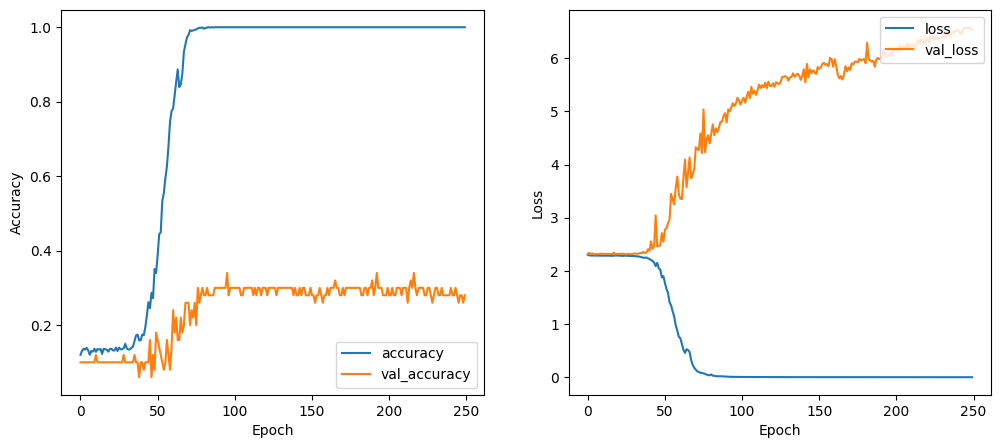

In [19]:
# Train the model
history = combined_model.fit(x = fused_train_features, 
    y = global_train_labels,
    batch_size=128,
    epochs=250,
    validation_data=(fused_validation_features, local_validation_labels),
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

Found 50 images belonging to 10 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 685ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


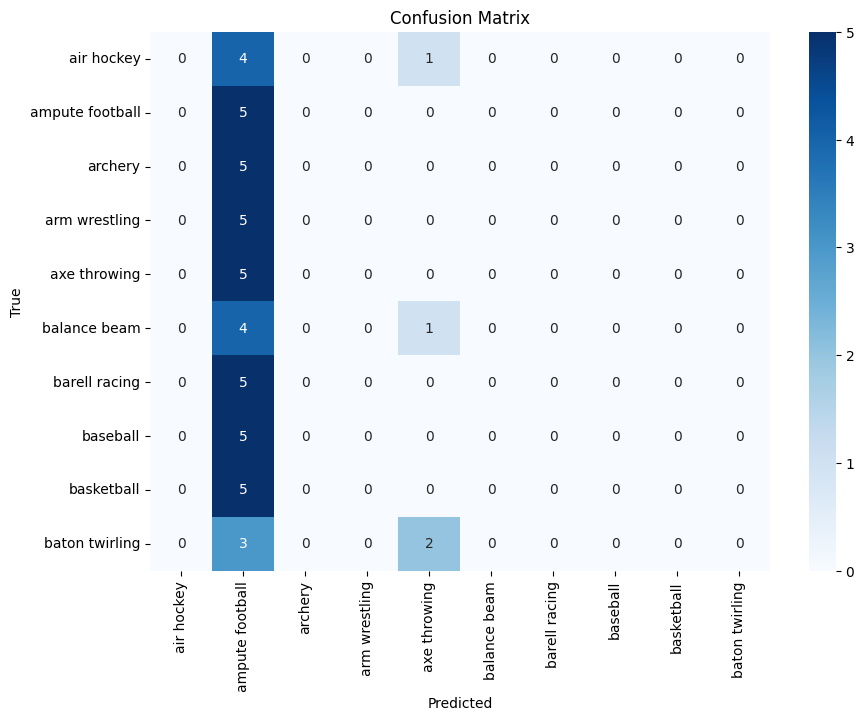

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Create ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Create test data generator
test_dg = test_datagen.flow_from_directory(
    test_data_dir,
    classes=selected_classes,
    class_mode='categorical',
    target_size=(299, 299),
    batch_size=128,
    shuffle=False,
    seed=42
)

# Extract local features for test data
test_local_features, test_labels = extract_local_features(test_dg, local_feature_extractor)

# Extract global features for test data
test_global_features, _ = extract_global_features(test_dg, global_feature_extractor)

# Generate predictions

fused_test_features = np.stack((test_local_features.reshape(50,32,32),
         test_global_features.reshape(50,32,32)),axis=3)

predictions = np.argmax(combined_model.predict(fused_test_features), axis=1)

# Extract true labels from test_labels
true_labels = np.argmax(test_labels, axis=1)

# Plot confusion matrix
def plot_confusion_matrix(labels, predictions, class_names):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Plot the confusion matrix with actual variables
plot_confusion_matrix(true_labels, predictions, selected_classes)

In [21]:
# Check the distribution of classes in the test data
class_counts = test_dg.classes
unique, counts = np.unique(class_counts, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class distribution in test data:", class_distribution)

Class distribution in test data: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5}


In [22]:
# Print out some predictions and check their correctness
for i in range(10,20):
    print(f"Image {i}: True label: {selected_classes[np.argmax(test_labels[i])]}, Predicted: {selected_classes[predictions[i]]}")

Image 10: True label: archery, Predicted: ampute football
Image 11: True label: archery, Predicted: ampute football
Image 12: True label: archery, Predicted: ampute football
Image 13: True label: archery, Predicted: ampute football
Image 14: True label: archery, Predicted: ampute football
Image 15: True label: arm wrestling, Predicted: ampute football
Image 16: True label: arm wrestling, Predicted: ampute football
Image 17: True label: arm wrestling, Predicted: ampute football
Image 18: True label: arm wrestling, Predicted: ampute football
Image 19: True label: arm wrestling, Predicted: ampute football
